In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import scipy.linalg

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Parameters

In [2]:
n_test = 100
n_train_max  = 1800  # this has to be larger than 4**n_qubits
reps = 1 

qubits_list = [1, 2, 3, 4, 5]
qubits_list = [5]

# Functions to generate data

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

# map data in [0,1] range
X = X / 255.0

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

# standardize data -- make mean 0 and std 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# choose only two classes '0' and '1' for now
train_filter = np.where((y_train == '0') | (y_train == '1'))
test_filter = np.where((y_test == '0') | (y_test == '1'))

# reduced training and test data with only 2 classes
x_train_red, y_train_red = X_train[train_filter], y_train[train_filter]
x_test_red, y_test_red = X_test[test_filter], y_test[test_filter]

# Reshape labels to one-hot encode them
y_train_red = y_train_red.reshape(-1, 1)
y_test_red = y_test_red.reshape(-1, 1)

# One-hot encode the labels
ohe = OneHotEncoder()
ohe.fit(y_train_red)
y_train = ohe.transform(y_train_red).toarray()
ohe.fit(y_test_red)
y_test = ohe.transform(y_test_red).toarray()

# Start Training

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Number of qubits:  5
1 : train samples:  304 / 1744
Rank of Kernel:  304
Mean Squared Error Test: 0.366630713011187
Mean Squared Error Train: 8.394038610232882e-31
1 : train samples:  544 / 1744
Rank of Kernel:  544
Mean Squared Error Test: 0.5049249943271423
Mean Squared Error Train: 6.044184195456392e-30
1 : train samples:  784 / 1744
Rank of Kernel:  784
Mean Squared Error Test: 1.2124334100974643
Mean Squared Error Train: 6.941487904987594e-29
1 : train samples:  1024 / 1744
Rank of Kernel:  1024
Mean Squared Error Test: 9231.239278609399
Mean Squared Error Train: 4.0413910505131585e-19
1 : train samples:  1264 / 1744


c:\Users\IoTLa\.conda\envs\ddqml\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  1024
Mean Squared Error Test: 1.297319396938271
Mean Squared Error Train: 0.04489601524531722
1 : train samples:  1504 / 1744


c:\Users\IoTLa\.conda\envs\ddqml\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  1024
Mean Squared Error Test: 0.8025625176656185
Mean Squared Error Train: 0.07619189631843516
1 : train samples:  1744 / 1744


c:\Users\IoTLa\.conda\envs\ddqml\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Rank of Kernel:  1024
Mean Squared Error Test: 0.5794354854406445
Mean Squared Error Train: 0.10110388349037083


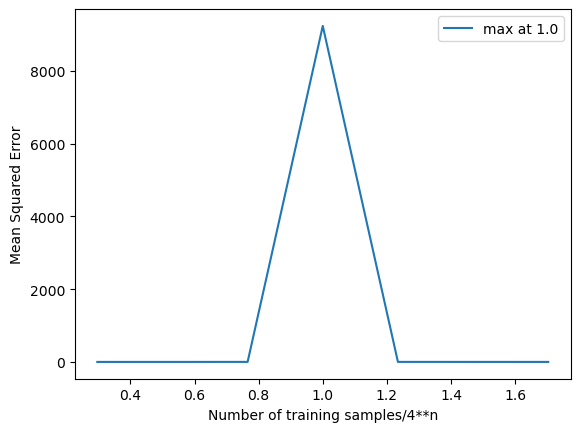

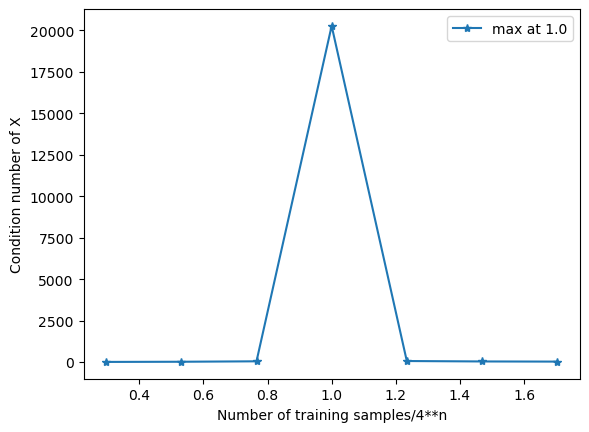

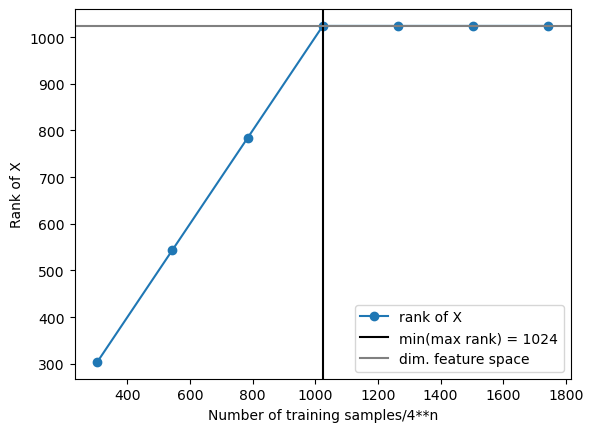

1024 /  1024


In [4]:
from sklearn.decomposition import PCA


for n_qubits in qubits_list:

    import os

    data_directory = f"Data/{n_qubits}_qubits"
    # Ensure the directory exists
    os.makedirs(f"./{data_directory}", exist_ok=True)

    graph_directory = f"Graphs/{n_qubits}_qubits"
    # Ensure the directory exists
    os.makedirs(f"./{graph_directory}", exist_ok=True)


    import numpy as np

    # Set random seed for reproducibility
    np.random.seed(42)

    def quantum_feature_map(x):
        """
        Feature map for quantum kernel.
        Adjust repetitions (reps) or gates if kernel is not full rank.
        """
        reps = n_qubits
        for r in range(reps):
            for i in range(len(x)):
                qml.RX(x[i], wires=i % n_qubits)
            for n in range(n_qubits - 1):
                qml.CNOT(wires=[n, n + 1])
            for i in range(len(x)):
                qml.RZ(x[i], wires=i % n_qubits)

    dev_kernel = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev_kernel)
    def kernel_state(x1):
        """
        Takes as input data and returns density matrix.
        Use this function to generate rho(X).
        """
        quantum_feature_map(x1)
        return qml.density_matrix(wires=range(n_qubits))

    projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        quantum_feature_map(x1)
        qml.adjoint(quantum_feature_map)(x2)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])


    # compute data matrix condition number and rank -------------------------------------------------------------------
    @qml.qnode(dev_kernel)
    def kernel_state(x1):
        """The quantum data encoding."""
        quantum_feature_map(x1)
        return qml.density_matrix(wires=range(n_qubits))

    def compute_rank(A, tol=None):
        U, s, Vh = scipy.linalg.svd(A)
        if tol is None:
            tol = max(A.shape) * np.spacing(np.max(s))
        rank = np.sum(s > tol)
        return rank

    
    print("*-"*20)
    print("Number of qubits: ", n_qubits)

    # Initialize PCA with the number of components
    to_use = 2 * n_qubits
    pca = PCA(n_components=to_use)

    # Fit the PCA model and transform the data
    x_train = pca.fit_transform(x_train_red)
    x_test = pca.transform(x_test_red)

    # choose only subset of data
    x_test = x_test[:n_test]
    y_test = y_test[:n_test]


    mse_arr = [[] for _ in range(reps)]
    mse_arr_train = [[] for _ in range(reps)]
    eig_vals_arr = [[] for _ in range(reps)]
    cond_no_arr = [[] for _ in range(reps)]
    rank_arr = [[] for _ in range(reps)]
    params = [[] for _ in range(reps)]
    K_train_arr = []

    for r in range(reps):

        x_train_max = x_train[r * n_train_max:(r + 1) * n_train_max]
        y_train_max = y_train[r * n_train_max:(r + 1) * n_train_max]

        if n_qubits == 1:
            limit_low, limit_up, step = 1, 8, 1
        elif n_qubits == 2:
            limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
        elif n_qubits == 3:
            limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
        elif n_qubits == 4:
            limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
        elif n_qubits == 5:
            limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240

        for n_train in range(limit_low, limit_up, step):
            x_train_krr = x_train_max[:n_train]
            y_train_krr = y_train_max[:n_train]
            print(r + 1, ": train samples: ", x_train_krr.shape[0], "/", limit_up - 1)

            K_train = kernel_matrix(x_train_krr, x_train_krr).astype(np.float64)
            K_test = kernel_matrix(x_test, x_train_krr).astype(np.float64)
            K_train_arr.append(K_train)

            kernel_ridge_model = KernelRidge(kernel='precomputed', alpha=0.0)
            kernel_ridge_model.fit(K_train, y_train_krr)

            predictions = kernel_ridge_model.predict(K_test)
            train_predictions = kernel_ridge_model.predict(K_train)

            params[r].append(kernel_ridge_model.dual_coef_)

            K_eig_vals = np.linalg.eig(K_train)[0]
            cond_no = np.linalg.cond(K_train)
            rank = np.linalg.matrix_rank(K_train)

            eig_vals_arr[r].append(K_eig_vals)
            cond_no_arr[r].append(cond_no)
            rank_arr[r].append(rank)
            print("Rank of Kernel: ", rank)

            mse = mean_squared_error(np.real(y_test), predictions)
            mse_arr[r].append(mse)
            print("Mean Squared Error Test:", mse)

            train_mse = mean_squared_error(y_train_krr, train_predictions)
            mse_arr_train[r].append(train_mse)
            print("Mean Squared Error Train:", train_mse)
        

    # compute data matrix condition number and rank -------------------------------------------------------------------
    no_train = 2**(2*n_qubits)
    cond_no_arr = []
    rank_arr = []
    for n in range(limit_low, limit_up, step):
        X = [kernel_state(x_train_max[m, :]).flatten().astype(np.complex128) for m in range(n)]
        cond_no = np.linalg.cond(X)
        cond_no_arr.append(cond_no)
        rank_arr.append(compute_rank(np.array(X)))


    import pickle

    # Creating a dictionary to store all the arrays
    data = {
        'mse_arr': mse_arr,
        'mse_arr_train': mse_arr_train,
        'eig_vals_arr': eig_vals_arr,
        'cond_no_arr': cond_no_arr,
        'rank_arr': rank_arr,
        'params': params,
        'K_train_arr': K_train_arr
    }

    # Saving the dictionary to a file using pickle
    with open(f'./{data_directory}/data_nqubits_{n_qubits}.pkl', 'wb') as f:
        pickle.dump(data, f)


    # import pickle

    # # Loading the data from the pickle file
    # with open(f'data_nqubits_{n_qubits}.pkl', 'rb') as f:
    #     loaded_data = pickle.load(f)

    # # Access the arrays after loading
    # mse_arr = loaded_data['mse_arr']
    # mse_arr_train = loaded_data['mse_arr_train']
    # eig_vals_arr = loaded_data['eig_vals_arr']
    # cond_no_arr = loaded_data['cond_no_arr']
    # rank_arr = loaded_data['rank_arr']
    # params = loaded_data['params']
    # K_train_arr = loaded_data['K_train_arr']


    mse_arr = np.array(mse_arr)
    mse_mean = np.mean(mse_arr, axis=0, dtype=np.float64)
    mse_std = np.std(mse_arr, axis=0) / np.log(10)

    mse_mean_train = np.mean(mse_arr_train, axis=0)
    mse_std_train = np.std(mse_arr_train, axis=0)

    # save all files -------------------------------------------------------------------
    np.savetxt(f"./{data_directory}/mse_mean_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean], newline='')
    np.savetxt(f"./{data_directory}/mse_std_nqubits_{n_qubits}_MNIST_Fashion", [mse_std], newline='')
    np.savetxt(f"./{data_directory}/mse_mean_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_mean_train], newline='')
    np.savetxt(f"./{data_directory}/mse_std_train_nqubits_{n_qubits}_MNIST_Fashion", [mse_std_train], newline='')
    np.savetxt(f"./{data_directory}/arrange_nqubits_{n_qubits}_MNIST_Fashion", [np.arange(limit_low, limit_up, step)], newline='')
    np.savetxt(f"./{data_directory}/rank_arr_nqubits_{n_qubits}MNIST_Fashion", [rank_arr], newline='')
    np.savetxt(f"./{data_directory}/cond_no_arr_nqubits_{n_qubits}MNIST_Fashion", [cond_no_arr], newline='')


    import matplotlib.pyplot as plt

    # Plotting Test MSE
    scenario = f"MNIST_Fashion_nqubits_{n_qubits}"
    plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, mse_mean, label=f"max at {range(limit_low, limit_up, step)[np.argmax(mse_mean)]/4**n_qubits}", marker="")
    plt.legend()
    plt.xlabel("Number of training samples/4**n")
    plt.ylabel("Mean Squared Error")
    plt.savefig(f"./{graph_directory}/{scenario}_MSE.png", dpi=500, bbox_inches='tight')
    plt.show()

    # Plotting condition number of kernel matrix
    plt.plot(np.arange(limit_low, limit_up, step)/4**n_qubits, cond_no_arr, label=f"max at {range(limit_low, limit_up, step)[np.argmax(cond_no_arr)]/4**n_qubits}", marker="*")
    plt.legend()
    plt.xlabel("Number of training samples/4**n")
    plt.ylabel("Condition number of X")
    plt.savefig(f"./{graph_directory}/{scenario}_cond_no_arr.png", dpi=500, bbox_inches='tight')
    plt.show()

    # Plotting Rank  of kernel matrix
    plt.plot(np.arange(limit_low, limit_up, step), rank_arr, label="rank of X", marker="o")
    plt.axvline(range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))], label=f"min(max rank) = {range(limit_low, limit_up, step)[np.min(np.where(np.array(rank_arr) == np.max(np.array(rank_arr))))]}", color="black")
    plt.axhline(no_train, color="grey", label="dim. feature space")
    plt.legend()
    plt.xlabel("Number of training samples/4**n")
    plt.ylabel("Rank of X")
    plt.savefig(f"./{graph_directory}/{scenario}_rank_arr.png", dpi=500, bbox_inches='tight')
    plt.show()

    rank = np.linalg.matrix_rank(X)
    print(rank, "/ ", no_train)
